In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tslearn
!pip install minisom
!pip install pytorch_lightning
!pip install pytorch_forecasting

     |████████████████████████████████| 793 kB 5.2 MB/s 
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=441e25a76c3b5341730568f2cc2a7bb45a72811ff7d806ed365eaa6c9b2040b4
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom
     |████████████████████████████████| 582 kB 5.3 MB/s 
     |████████████████████████████████| 408 kB 44.3 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 136 kB 43.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 51.6 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 127 kB 4

In [1]:
import glob
import copy
from pathlib import Path
from datetime import datetime
import os
import re
import math
from fnmatch import fnmatch
import copy
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from minisom import MiniSom

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import operator as op
from numpy import loadtxt
import ast
import pickle

2022-04-20 10:19:48.981892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 10:19:48.981929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
#importação dos dados de microgrid

!tar -xvf "/content/drive/Shareddrives/SmartHome/2013/microgrid.tar.gz" -C "/content/"

path =r'/content/microgrid'
all_files = glob.glob(path + "/*.csv")
#dicionario que contem os dataframes dos csvs das casas
dfs = {}
#Le todos os arquivos no path e cria dataframes com os dados, colocando os dataframes
#em um dicionario
for filename in all_files:
    #linhas para achar o nome da casa, que é usado como chave no dicionario para encontrar
    #o dataframe da casa
    start = filename.find('b') + 1
    end = filename.find('.', start)
    df = pd.read_csv(filename, index_col=0, header=0)
    #reverte o dataframe lido, pois ele esta na ordem reversa de tempo.
    df = df[::-1]
    df.index.name = 'Timestamp'
 
    df.columns = ['Potencia_Real']
    dfs[filename[start:end]] = df

#print(dfs)

In [ ]:
#Remoção das casas com potencias iguais em todos as linhas

for k in list(dfs.keys()):
     if (len(dfs[k].Potencia_Real.unique()) == 1):
         del dfs[k]
     elif (len(dfs[k].Potencia_Real) < 1439):
       del dfs[k]
#len(dfs)
#print(dfs)

In [ ]:
#Convertendo Timestamp do Unix para datetime

for k in list(dfs.keys()): 
        dfs[k].index = dfs[k].index.map(lambda x : datetime.utcfromtimestamp(x).strftime('%H:%M'))
#print(dfs)

In [ ]:

X_train = np.zeros(shape=(len(dfs),1439))
X_names = []

i = 0
for key, value in dfs.items():
  X_train[i] = value["Potencia_Real"]
  X_names.append(key)
  i = i + 1




In [ ]:
print(len(X_train))

388


In [ ]:
wcss = []
scores = []
for i in range(2,7):
  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", random_state=0,max_iter=50)
  %memit labels = km.fit_predict(X_train)
  wcss.append(km.inertia_)
  scores.append(silhouette_score(X_train, labels, metric="dtw", random_state=0))
  print(i)

fig = plt.figure(figsize=(10, 8))
plt.plot(range(2,7),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
plt.savefig('/content/drive/MyDrive/TCC_Imagens/elbow kmeans.png')

fig = plt.figure(figsize=(10, 8))
plt.plot(range(2,7),scores,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.show()
plt.savefig('/content/drive/MyDrive/TCC_Imagens/silhouette score kmeans.png')

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
    plt.savefig('/content/drive/MyDrive/TCC_Imagens/Smartgrid_Cluster_Som.png')

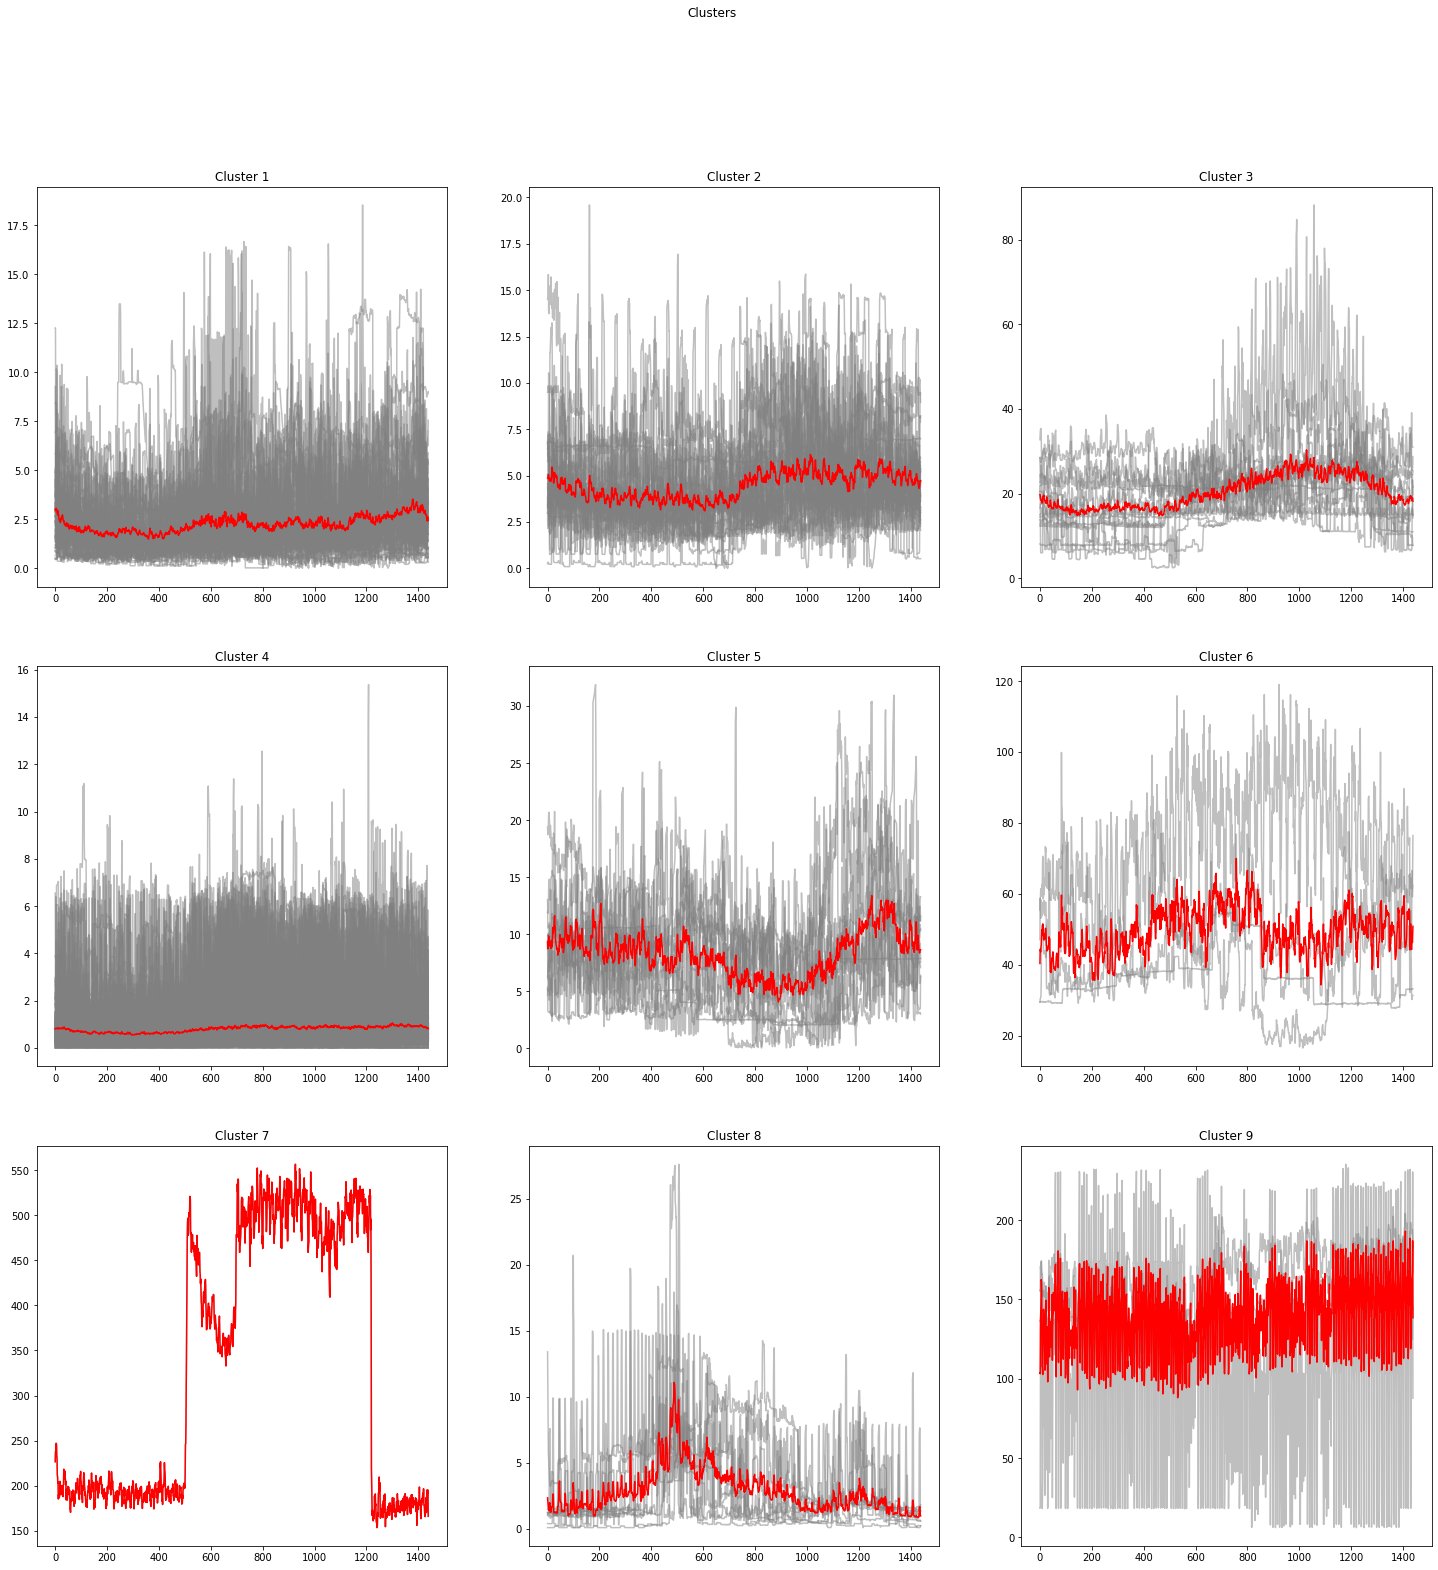

<Figure size 432x288 with 0 Axes>

In [ ]:
som_x = som_y = 3 #math.ceil(math.sqrt(math.sqrt(len(X_train))))

som = MiniSom(som_x, som_y,len(X_train[0]), sigma=0.3, learning_rate = 0.1)
som.random_weights_init(X_train)
som.train(X_train, 50000)
win_map = som.win_map(X_train)

plot_som_series_averaged_center(som_x, som_y, win_map)

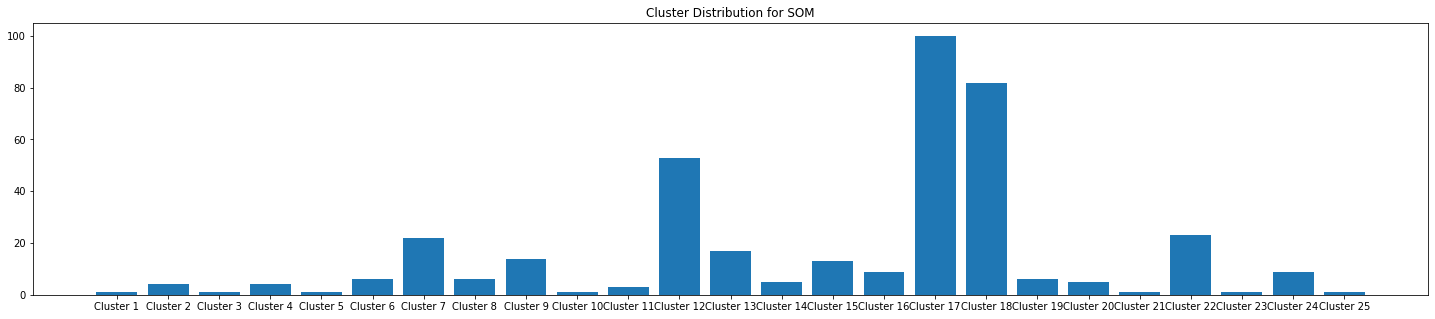

In [ ]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
names = []
for k in list(dfs.keys()): 
    names.append(k)
cluster_map = []
for idx in range(len(X_train)):
    winner_node = som.winner(X_train[idx])
    cluster_map.append((names[idx],winner_node[0]*som_y+winner_node[1]+1))

clusters = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")


In [ ]:
def plot_casa(numero_casa):
  dfs[numero_casa]['Potencia_Real'].plot()
  plt.show()

In [ ]:
plot_casa('87')

KeyError: ignored

In [ ]:
dfs_copy = dfs.copy()
for k in list(dfs_copy.keys()): 
  dfs_copy[k].insert(0, 'time_idx', range(0, 0 + len(df)))
  dfs_copy[k].time_idx = dfs_copy[k].time_idx.astype(int)
  dfs_copy[k]['log_Potencia_Real'] = np.log(dfs[k].Potencia_Real,where=dfs[k].Potencia_Real > 0) 
  dfs_copy[k]['Group'] = k
  dfs_copy[k]['Cluster'] = clusters.loc[k, 'Cluster']
data = pd.concat(dfs_copy)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 558332 entries, ('147', '00:00') to ('268', '23:58')
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_idx           558332 non-null  int64  
 1   Potencia_Real      558332 non-null  float64
 2   log_Potencia_Real  558332 non-null  float64
 3   Group              558332 non-null  object 
 4   Cluster            558332 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 23.5+ MB


In [ ]:
data.tail()

time_idx  Potencia_Real  log_Potencia_Real Group  Cluster
    Timestamp                                                           
268 23:54          1434       4.595167           1.525005   268        7
    23:55          1435       2.001000           0.693647   268        7
    23:56          1436       0.273533          -1.296332   268        7
    23:57          1437       0.273067          -1.298039   268        7
    23:58          1438       0.272950          -1.298467   268        7

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
data.time_idx = data.time_idx.astype(int)
training_cutoff = data["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
                             data[lambda x: x.time_idx <= training_cutoff],
                             time_idx="time_idx",
                             target="Potencia_Real",
                             group_ids=["Group","Cluster"],
                             min_encoder_length=max_encoder_length // 2
                             max_encoder_length=max_encoder_length,
                             min_prediction_length=1,
                             max_prediction_length=max_prediction_length,
                             time_varying_known_reals=["time_idx"],
                             time_varying_unknown_categoricals=[],
                             time_varying_unknown_reals=[
                                                         "Potencia_Real",
                                                         "log_Potencia_Real"
                                                         ],
                             add_relative_time_idx=True,
                             add_target_scales=True,
                             add_encoder_length=True,
                             )
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.6209926009178162

In [ ]:
# configure network and trainer
pl.seed_everything(0)
trainer = pl.Trainer(
    gpus=0,
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,  
    hidden_continuous_size=8,  
    output_size=7, 
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 19.5k


Global seed set to 0


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_58c8ee77-fe2d-40dc-96ce-38813081bf9b.ckpt


suggested learning rate: 3.467368504525316e-05


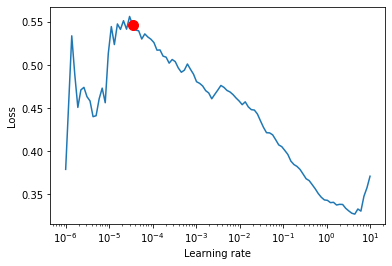

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.002,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResid

Number of parameters in network: 19.5k


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:


# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
)

with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print(study.best_trial.params)

[I 2022-01-21 19:33:05,024] A new study created in memory with name: no-name-839175d3-f5a7-4288-85fc-bee214b7c105
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
[I 2022-01-21 19:45:04,886] Trial 0 finished with value: 0.1571301519870758 and parameters: {'gradient_clip_val': 0.1709275828681533, 'hidden_size': 68, 'dropout': 0.16705064854317178, 'hidden_continuous_size': 9, 'attention_head_size': 4, 'learning_rate': 0.014834625450476657}. Best is trial 0 with value: 0.1571301519870758.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
[I 2022-01-21 19:55:53,631] Trial 1 finished with value: 0.1653880625963211 and parameters: {'gradient_clip_val': 0.012222647799257138, 'hidden_size': 45, 'dropout': 0.154143196288777, 'hidden_continuous_size': 38, 'attention_head_size': 1, 'learning_rate': 0.022292859052029778}. Best is trial

{'gradient_clip_val': 0.1709275828681533, 'hidden_size': 68, 'dropout': 0.16705064854317178, 'hidden_continuous_size': 9, 'attention_head_size': 4, 'learning_rate': 0.014834625450476657}


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.6075)

In [ ]:
data_cluster = {}
for c in data.Cluster.unique():
    data_cluster[c] = data.loc[data['Cluster'] == c]
print(data_cluster)

{19:                time_idx  Potencia_Real  log_Potencia_Real Group  Cluster
    Timestamp                                                           
91  00:00             0       3.337100           1.205102    91       19
    00:01             1       3.406800           1.225773    91       19
    00:02             2       3.089700           1.128074    91       19
    00:03             3       3.090767           1.128419    91       19
    00:04             4       3.189583           1.159890    91       19
...                 ...            ...                ...   ...      ...
313 23:54          1434       1.036033           0.035399   313       19
    23:55          1435       1.043917           0.042980   313       19
    23:56          1436       1.035000           0.034401   313       19
    23:57          1437       1.031283           0.030804   313       19
    23:58          1438       1.056700           0.055151   313       19

[30219 rows x 5 columns], 9:                t

In [ ]:
print(data_cluster.keys())

In [ ]:
for key, val in data_cluster.items():
  max_prediction_length = 6
  max_encoder_length = 24
  val.time_idx = val.time_idx.astype(int)
  training_cutoff = val["time_idx"].max() - max_prediction_length
  training = TimeSeriesDataSet(
                             val[lambda x: x.time_idx <= training_cutoff],
                             time_idx="time_idx",
                             target="Potencia_Real",
                             group_ids=["Group","Cluster"],
                             min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
                             max_encoder_length=max_encoder_length,
                             min_prediction_length=1,
                             max_prediction_length=max_prediction_length,
                             time_varying_known_reals=["time_idx"],
                             time_varying_unknown_categoricals=[],
                             time_varying_unknown_reals=[
                                                         "Potencia_Real",
                                                         "log_Potencia_Real"
                                                         ],
                             add_relative_time_idx=True,
                             add_target_scales=True,
                             add_encoder_length=True,
                             )
  validation = TimeSeriesDataSet.from_dataset(training, val, predict=True, stop_randomization=True)
  batch_size = 128  # set this between 32 to 128
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
  val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
  study = optimize_hyperparameters(
     train_dataloader,
     val_dataloader,
     model_path="optuna_test",
     n_trials=50,
     max_epochs=50,
     gradient_clip_val_range=(0.01, 1.0),
     hidden_size_range=(8, 128),
     hidden_continuous_size_range=(8, 128),
     attention_head_size_range=(1, 4),
     learning_rate_range=(0.01, 0.1),
     dropout_range=(0.1, 0.3),
     trainer_kwargs=dict(limit_train_batches=30),
     reduce_on_plateau_patience=4,
     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
 )

# save study results - also we can resume tuning at a later point in time
  with open(f"test_study_cluster_{key}.pkl", "wb") as fout:
     pickle.dump(study, fout)

# show best hyperparameters
  print(study.best_trial.params)
  

[I 2022-01-21 02:42:28,209] A new study created in memory with name: no-name-e5601ff8-0003-48ba-b6d3-d735955471ba
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning:

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packa

{'gradient_clip_val': 0.40667804130905916, 'hidden_size': 63, 'dropout': 0.16787587263575043, 'hidden_continuous_size': 12, 'attention_head_size': 1, 'learning_rate': 0.07439980095742976}


[I 2022-01-21 04:22:11,361] A new study created in memory with name: no-name-555d0144-a297-4342-b228-5c5d3bbfb4f0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning:

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packa

{'gradient_clip_val': 0.12706611693895278, 'hidden_size': 111, 'dropout': 0.29256542912815187, 'hidden_continuous_size': 55, 'attention_head_size': 3, 'learning_rate': 0.043643413518951873}


[I 2022-01-21 06:39:41,760] A new study created in memory with name: no-name-703396fa-4872-4616-bb83-861cfdeec4ce
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning:

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packa

{'gradient_clip_val': 0.4227971632004052, 'hidden_size': 21, 'dropout': 0.20216818103900822, 'hidden_continuous_size': 14, 'attention_head_size': 3, 'learning_rate': 0.034015814394422174}


[I 2022-01-21 07:38:41,524] A new study created in memory with name: no-name-eb9124a5-aa0b-4fb9-bb5c-e280f3e6775b
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning:

Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packa

In [ ]:

def prepara_dataset(dataframes, n):
   #Preparando os dados para a predição de série temporal
   #Assumi que o valor atual de potencia pode ser previsto usando os n-1 ultimos valores da potencia
  for k in list(dataframes.keys()):

    #Aplicando logaritmo na potencia real 
    dataframes[k]['log_Potencia_Real'] = np.log(dataframes[k].Potencia_Real,where=dataframes[k].Potencia_Real > 0)

    #Loop que calcula os valores da diferença entre a portencia atual, a potencia anterior e a potencia anterior da anterior
    for i in range(n):

      dataframes[k][f'Potencia_Real_lag_{i+1}'] = dataframes[k].Potencia_Real.shift(i+1)

      dataframes[k].dropna(inplace=True)

      dataframes[k][f'log_Potencia_Real_lag_{i+1}'] = np.log(dataframes[k][f'Potencia_Real_lag_{i+1}'],where=dataframes[k][f'Potencia_Real_lag_{i+1}'] > 0)

      dataframes[k][f'log_difference_{i+1}'] = dataframes[k].log_Potencia_Real - dataframes[k][f'log_Potencia_Real_lag_{i+1}']

prepara_dataset(dfs, 3)
print(dfs)

In [ ]:
def grid_search_casa(dataframes, numero_casa, regressor, hiperparametros, scoring):
  X, Y = np.array(dataframes[numero_casa].loc[:, 'log_difference_2':]), np.array(dataframes[numero_casa]['log_difference_1'])
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)
  clf = GridSearchCV(regressor, hiperparametros,scoring = scoring)
  clf.fit(X_train, Y_train)

  return -clf.best_score_, clf.best_params_, clf.predict(X_test)

In [ ]:
scoring = 'neg_mean_absolute_error'

In [ ]:

n_estimator = [5,10,25,50,500]
learning_rate = [0.01,0.05,0.1,0.15,0.2]
parameters_adaboost = {'n_estimators':n_estimator, 'learning_rate':learning_rate }
mdl_adaboost = AdaBoostRegressor()
grid_search_casa(dfs,'994', mdl_adaboost, parameters_adaboost, scoring)

In [ ]:
C=[1.0,10] 
epsilon=[0.1,0.2,0.5]
parameters_svc = {'C':C, 'epsilon':epsilon}
svc = svm.SVR()
grid_search_casa(dfs,'994', svc, parameters_svc, scoring)

In [ ]:
n_neighbors=[1,2,5,10,20] 
parameters_knr = {'n_neighbors':n_neighbors}
neigh = KNeighborsRegressor()
grid_search_casa(dfs,'994', neigh,parameters_knr,scoring)

In [ ]:
tree = DecisionTreeRegressor(criterion='absolute_error',random_state=0)
parameters_tree = {}
grid_search_casa(dfs,'994', tree,parameters_tree,scoring)

In [ ]:
extra_tree = ExtraTreesRegressor(criterion='absolute_error', random_state=0)
n_estimator = [5,10,25,50,500]
parameters_extra_tree = {'n_estimators':n_estimator}
grid_search_casa(dfs,'994', extra_tree,parameters_extra_tree,scoring)

In [ ]:
def prever_casa(dataframes,numero_casa, regressor, hiperparametros, scoring):

  #Código de predição de uma casa qualquer
  X, Y = np.array(dataframes[numero_casa].loc[:, 'log_difference_2':]), np.array(dataframes[numero_casa]['log_difference_1'])

  #Fazendo o split em conjunto de teste e conjunto de treino
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)
  #faz o gridsearch para encontrar os melhores hiperparametros
  _,best_params, pred = grid_search_casa(dataframes,numero_casa, regressor, hiperparametros, scoring)

  test_size = X_test.shape[0]
  #Plota os resultados do ultimo pedaço de codigo
  plt.plot(list(range(test_size)), np.exp(dfs[numero_casa].tail(test_size).log_Potencia_Real_lag_1  + pred), label='predicted', color='red')
  plt.plot(list(range(test_size)), dfs[numero_casa].tail(test_size).Potencia_Real, label='real', color='blue')
  plt.legend(loc='best')
  plt.title('Predicted vs Real with log difference values')

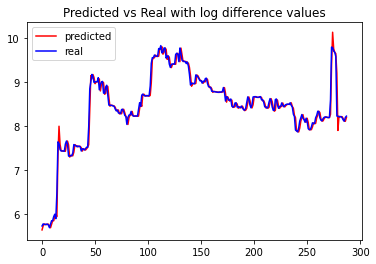

In [ ]:
n_estimator = [5,10,25,50,500]
learning_rate = [0.01,0.05,0.1,0.15,0.2]
parameters_adaboost = {'n_estimators':n_estimator, 'learning_rate':learning_rate }
mdl_adaboost = AdaBoostRegressor()
prever_casa(dfs,'994', mdl_adaboost, parameters_adaboost, scoring)

In [ ]:
#Pedaço de codigo para encontrar os melhores hiperparametros para as 400 casas

def grid_search_todas_casas(dataframes,regressor, hiperparametros, scoring):
  MAE_dfs_k = {}
  params_k = {}
  for k in list(dataframes.keys()):
    best_mae,best_params,_ = grid_search_casa(dataframes,k,regressor, hiperparametros, scoring)
    MAE_dfs_k[k] = best_mae
    params_k[k] = best_params
  return MAE_dfs_k, params_k




In [ ]:
scoring = 'neg_mean_absolute_error'
n_estimator = [5,10,25,50,500]
learning_rate = [0.01,0.05,0.1,0.15,0.2]
parameters_adaboost = {'n_estimators':n_estimator, 'learning_rate':learning_rate }
mdl_adaboost = AdaBoostRegressor(random_state=0)
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,mdl_adaboost, parameters_adaboost, scoring)
df_MAE_k_ada = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_ada['Hiperparametros'] = df_MAE_k_ada['Casa'].map(params_k)
df_MAE_k_ada.set_index('Casa', inplace=True)
df_MAE_k_ada.describe()

In [ ]:
df_MAE_k_ada.to_csv("drive/MyDrive/data_grid_search_adaboost_SmartGrid.csv")

In [ ]:
C=[1.0,10] 
epsilon=[0.1,0.2,0.5]
parameters_svr = {'C':C, 'epsilon':epsilon}
svr = svm.SVR()
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,svr, parameters_svr, scoring)
df_MAE_k_svr = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_svr['Hiperparametros'] = df_MAE_k_svr['Casa'].map(params_k)
df_MAE_k_svr.set_index('Casa', inplace=True)
df_MAE_k_svr.describe()

In [ ]:
df_MAE_k_svr.to_csv("drive/MyDrive/data_grid_search_svr_SmartGrid.csv")

In [ ]:
n_neighbors=[1,2,5,10,20] 
parameters_knr = {'n_neighbors':n_neighbors}
neigh = KNeighborsRegressor()
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,neigh, parameters_knr, scoring)
df_MAE_k_knr = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_knr['Hiperparametros'] = df_MAE_k_knr['Casa'].map(params_k)
df_MAE_k_knr.set_index('Casa', inplace=True)
df_MAE_k_knr.describe()

In [ ]:
df_MAE_k_knr.to_csv("drive/MyDrive/data_grid_search_knr_SmartGrid.csv")

In [ ]:
tree = DecisionTreeRegressor(criterion='absolute_error',random_state=0)
parameters_tree = {}
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,tree, parameters_tree , scoring)
df_MAE_k_decision_tree = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_decision_tree['Hiperparametros'] = df_MAE_k_decision_tree['Casa'].map(params_k)
df_MAE_k_decision_tree.set_index('Casa', inplace=True)
df_MAE_k_decision_tree.describe()

In [ ]:
df_MAE_k_decision_tree.to_csv("drive/MyDrive/data_grid_search_decisiontree_SmartGrid.csv")

In [ ]:
extra_tree = ExtraTreesRegressor(criterion='absolute_error', random_state=0)
n_estimator = [5,10,25,50,500]
parameters_extra_tree = {'n_estimators':n_estimator}
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,extra_tree, parameters_extra_tree, scoring)
df_MAE_k_extra_tree = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_extra_tree['Hiperparametros'] = df_MAE_k_extra_tree['Casa'].map(params_k)
df_MAE_k_extra_tree.set_index('Casa', inplace=True)
df_MAE_k_extra_tree.describe()

In [ ]:
df_MAE_k_extra_tree.to_csv("drive/MyDrive/data_grid_search_extratree_SmartGrid.csv")

In [ ]:
mlp = MLPRegressor(random_state=0)
max_iter = [100,200,300,400,500]
parameters_mlp = {'max_iter':max_iter}
MAE_dfs_k, params_k = grid_search_todas_casas(dfs,mlp, parameters_mlp, scoring)
df_MAE_k_mlp = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
df_MAE_k_mlp['Hiperparametros'] = df_MAE_k_mlp['Casa'].map(params_k)
df_MAE_k_mlp.set_index('Casa', inplace=True)
df_MAE_k_mlp.describe()

In [ ]:
df_MAE_k_mlp.to_csv("drive/MyDrive/data_grid_search_mlp_SmartGrid.csv")

In [ ]:
df_MAE_k_ada = pd.read_csv("drive/MyDrive/data_grid_search_adaboost_SmartGrid.csv")
df_MAE_k_svr = pd.read_csv("drive/MyDrive/data_grid_search_svr_SmartGrid.csv")
df_MAE_k_knr = pd.read_csv("drive/MyDrive/data_grid_search_knr_SmartGrid.csv")
df_MAE_k_decision_tree = pd.read_csv("drive/MyDrive/data_grid_search_decisiontree_SmartGrid.csv")
df_MAE_k_extra_tree = pd.read_csv("drive/MyDrive/data_grid_search_extratree_SmartGrid.csv")
df_MAE_k_mlp = pd.read_csv("drive/MyDrive/data_grid_search_mlp_SmartGrid.csv")

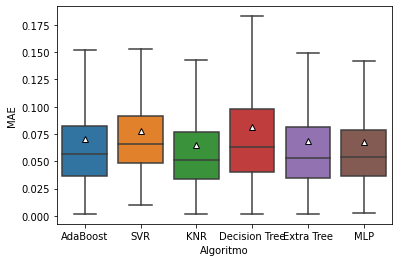

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt, operator as op
aux_df = pd.DataFrame()
aux_df['AdaBoost'] = df_MAE_k_ada['MAE']
aux_df['SVR'] = df_MAE_k_svr['MAE']
aux_df['KNR'] = df_MAE_k_knr['MAE']
aux_df['Decision Tree'] = df_MAE_k_decision_tree['MAE']
aux_df['Extra Tree'] = df_MAE_k_extra_tree['MAE']
aux_df['MLP'] = df_MAE_k_mlp['MAE']
ax = sns.boxplot(data=aux_df,showfliers = False, showmeans=True,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}).set(
    xlabel='Algoritmo', 
    ylabel='MAE')  
plt.show()

plt.clf()
plt.close()

In [ ]:
print(df_MAE_k_ada.loc[df_MAE_k_ada['MAE'].idxmax()])

In [ ]:
print(df_MAE_k_knr.loc[df_MAE_k_knr['MAE'].idxmax()])

In [ ]:
print(df_MAE_k_decision_tree.loc[df_MAE_k_decision_tree['MAE'].idxmax()])

In [ ]:
print(df_MAE_k_svr.loc[df_MAE_k_svr['MAE'].idxmax()])

In [ ]:
print(df_MAE_k_extra_tree.loc[df_MAE_k_extra_tree['MAE'].idxmax()])

In [ ]:
print(df_MAE_k_mlp.loc[df_MAE_k_mlp['MAE'].idxmax()])

In [ ]:
def media_hiperparametros(dataframes,regressor, dataframe_hiperparametros, scoring, parameters_regressor):
  hiperparameter_sum = [0] * len(parameters_regressor)
  for index, row in dataframe_hiperparametros.iterrows():
     aux_dict = ast.literal_eval(row['Hiperparametros'])
     for idx, key in enumerate(parameters_regressor):
      hiperparameter_sum[idx] += aux_dict[key]
  parameters = {}
  for idx, key  in enumerate(parameters_regressor):
    if type(hiperparameter_sum[idx]) is int:
      parameters[key] = [int(hiperparameter_sum[idx]/len(dataframe_hiperparametros.index))]
    else:
      parameters[key] = [hiperparameter_sum[idx]/len(dataframe_hiperparametros.index)]
  MAE_dfs_k, _ = grid_search_todas_casas(dataframes,regressor, parameters, scoring)
  df_media = pd.DataFrame(MAE_dfs_k.items(), columns=['Casa', 'MAE'])
  df_media.set_index('Casa', inplace=True)
  return df_media

In [ ]:
parameters_adaboost = ['n_estimators', 'learning_rate']
mdl_adaboost = AdaBoostRegressor(random_state=0)
df_media_k_ada = media_hiperparametros(dfs,mdl_adaboost, df_MAE_k_ada, scoring,parameters_adaboost)
df_media_k_ada.describe()

,MAE
count,388.000000
mean,0.074696
std,0.084681
min,0.002232
25%,0.038314
50%,0.058645
75%,0.087318
max,1.349509


In [ ]:
parameters_knr = ['n_neighbors']
neigh = KNeighborsRegressor()
df_media_k_knr = media_hiperparametros(dfs,neigh,df_MAE_k_knr, scoring, parameters_knr)
df_media_k_knr.describe()

,MAE
count,388.000000
mean,0.071762
std,0.076311
min,0.002556
25%,0.038106
50%,0.056804
75%,0.085315
max,1.174638


In [ ]:
parameters_svr = ['C', 'epsilon']
svr = svm.SVR()
df_media_k_svr = media_hiperparametros(dfs,svr,df_MAE_k_svr, scoring,parameters_svr)
df_media_k_svr.describe()

,MAE
count,388.000000
mean,0.084620
std,0.061403
min,0.009639
25%,0.053544
50%,0.073174
75%,0.096429
max,0.837587


In [ ]:
df_MAE_k_svr.describe()

,Casa,MAE
count,389.000000,389.000000
mean,454.588689,0.077900
std,312.927844,0.059512
min,6.000000,0.009639
25%,178.000000,0.048640
50%,339.000000,0.065909
75%,738.000000,0.091548
max,1069.000000,0.839412


In [ ]:
tree = DecisionTreeRegressor(criterion='absolute_error',random_state=0)
parameters_tree = {}
df_media_k_decision_tree = media_hiperparametros(dfs,tree, df_MAE_k_decision_tree , scoring, parameters_tree)
df_media_k_decision_tree.describe()

,MAE
count,388.000000
mean,0.081897
std,0.091594
min,0.002759
25%,0.041236
50%,0.064320
75%,0.099265
max,1.399896


In [ ]:
extra_tree = ExtraTreesRegressor(criterion='absolute_error', random_state=0)
parameters_extra_tree = ['n_estimators']
df_media_k_extra_tree = media_hiperparametros(dfs,extra_tree,df_MAE_k_extra_tree, scoring, parameters_extra_tree)
df_media_k_extra_tree.describe()

,MAE
count,388.000000
mean,0.065668
std,0.076960
min,0.001234
25%,0.033583
50%,0.051569
75%,0.079445
max,1.226729


In [ ]:
mlp = MLPRegressor(random_state=0)
parameters_mlp = ['max_iter']
df_media_k_mlp = media_hiperparametros(dfs,mlp,df_MAE_k_mlp, scoring, parameters_mlp)
df_media_k_mlp.describe()

,MAE
count,388.000000
mean,0.070165
std,0.075573
min,0.002939
25%,0.037681
50%,0.055071
75%,0.081883
max,1.175204


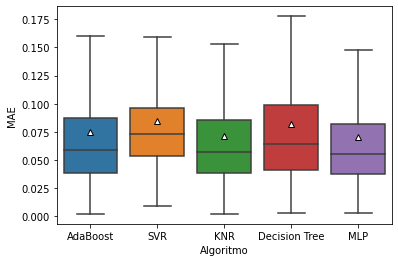

In [ ]:
aux_df = pd.DataFrame()
aux_df['AdaBoost'] = df_media_k_ada['MAE']
aux_df['SVR'] = df_media_k_svr['MAE']
aux_df['KNR'] = df_media_k_knr['MAE']
aux_df['Decision Tree'] = df_media_k_decision_tree['MAE']
#aux_df['Extra Tree'] = df_media_k_extra_tree['MAE']
aux_df['MLP'] = df_media_k_mlp['MAE']
ax = sns.boxplot(data=aux_df,showfliers = False, showmeans=True,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}).set(
    xlabel='Algoritmo', 
    ylabel='MAE')  
plt.show()

plt.clf()
plt.close()

In [ ]:
for k in list(dfs.keys()): 
  dfs[k]['Cluster'] = clusters.loc[k, 'Cluster']

In [ ]:
C=[1.0,10] 
epsilon=[0.1,0.2,0.5]
parameters_svc = {'C':C, 'epsilon':epsilon}
svc = svm.SVR()
results = dict.fromkeys(range(1,26), [])
for k in list(dfs.keys()):
  result,_,_ = grid_search_casa(dfs,k, svc, parameters_svc, scoring)
  print(dfs[k].Cluster.iloc[0],results[dfs[k].Cluster.iloc[0]])
  #print(result,dfs[k].Cluster.iloc[0])
  results[dfs[k].Cluster.iloc[0]]= results[dfs[k].Cluster.iloc[0]] + [result]
 


In [ ]:
pd.DataFrame.from_dict(results).head()

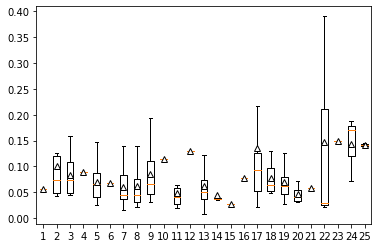

In [ ]:
# or backwards compatable   
labels, data = results.keys(), results.values()

plt.boxplot(data,showfliers = False, showmeans=True,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"})
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [ ]:
def cross_validation_melhor_casa(dfs,numero_casa,regressor,splits=5):
  MAE_dfs_best = {}
  dfks_best = dfs[numero_casa]
  
  X_best, Y_best = np.array(dfks_best[numero_casa].loc[:, 'log_difference_2':]), np.array(dfks_best['log_difference_1'])

  for k in list(dfs.keys()):
    X, Y = np.array(dfs[numero_casa].loc[:, 'log_difference_2':]), np.array(dfs[numero_casa]['log_difference_1'])
  
    dfs_k_spliter = TimeSeriesSplit(n_splits=splits)

    dfs_k_log_potencia_real = np.array(dfs[k].copy().reset_index().log_Potencia_Real_lag_1)
    dfs_k_potencia_real = np.array(dfs[k].copy().reset_index().Potencia_Real_lag_1)

    metric_iter = {}

    for idx, val in enumerate(dfs_k_spliter.split(X)):
    
            train_i, test_i = val

            X_train, X_test = X_best[train_i], X[test_i]
            Y_train, Y_test = Y_best[train_i], Y[test_i]

            regressor.fit(X_train, Y_train)

            pred = regressor.predict(X_test)
        
            pred_untransform = [np.exp(val_test + val_pred) for val_test, val_pred in zip(dfs_k_log_potencia_real[test_i], pred)]
        
            real = dfs_k_potencia_real[test_i]

            metric_iter[f'iter_{idx + 1}'] = mean_absolute_error(real, pred_untransform)
  
    MAE_dfs_best[k] = np.mean(list(metric_iter.values()))
  df_MAE_best = pd.DataFrame(MAE_dfs_best.items(), columns=['Casa', 'MAE'])
  df_MAE_best.set_index('Casa', inplace=True)
  return df_MAE_best

In [ ]:
Best_MAE_svr = '319'
best_C = 10
best_epsilon = 0.1
svr = svm.SVR(C=best_C,epsilon=best_epsilon)
df_MAE_best_svr = cross_validation_melhor_casa(dfs,Best_MAE_svr,svr)
df_MAE_best_svr.to_csv("drive/MyDrive/data_grid_search_svr_best_SmartGrid.csv")

In [ ]:
Best_MAE_knr = '319'
best_n = 2
neigh = KNeighborsRegressor(n_neighbors=best_n)
df_MAE_best_knr = cross_validation_melhor_casa(dfs,Best_MAE_knr,neigh) 
df_MAE_best_knr.to_csv("drive/MyDrive/data_grid_search_knr_best_SmartGrid.csv")

In [ ]:
Best_MAE_extra_tree = '319'
best_estimators = 500
extra_tree = ExtraTreesRegressor(n_estimators=best_estimators,criterion='absolute_error', random_state=0)
df_MAE_best_extra_tree = cross_validation_melhor_casa(dfs,Best_MAE_extra_tree,extra_tree)
df_MAE_best_extra_tree.to_csv("drive/MyDrive/data_grid_search_extratree_best_SmartGrid.csv")

In [ ]:
Best_MAE_tree = '319'
tree = DecisionTreeRegressor(criterion='absolute_error',random_state=0)
df_MAE_best_tree = cross_validation_melhor_casa(dfs,Best_MAE_tree,tree)
df_MAE_best_tree.to_csv("drive/MyDrive/data_grid_search_decisiontree_best_SmartGrid.csv")

In [ ]:
Best_MAE_mlp = '319'
best_iter = 100
best_n = 5
mlp = MLPRegressor(max_iter=best_iter,random_state=0)
df_MAE_best_mlp = cross_validation_melhor_casa(dfs,Best_MAE_mlp,mlp)
df_MAE_best_mlp.to_csv("drive/MyDrive/data_grid_search_mlp_best_SmartGrid.csv")

In [ ]:
Best_MAE_ada = '319'
best_rate = 0.05
best_n = 5
mdl_adaboost = AdaBoostRegressor(n_estimators=best_n, learning_rate=best_rate,random_state=0)
df_MAE_best_ada = cross_validation_melhor_casa(dfs,Best_MAE_ada,mdl_adaboost)
df_MAE_best_ada.to_csv("drive/MyDrive/data_grid_search_ada_best_SmartGrid.csv")

In [ ]:
df_MAE_best_ada = pd.read_csv("drive/MyDrive/data_grid_search_adaboost_SmartGrid.csv")
df_MAE_best_svr = pd.read_csv("drive/MyDrive/data_grid_search_svr_best_SmartGrid.csv")
df_MAE_best_knr = pd.read_csv("drive/MyDrive/data_grid_search_knr_best_SmartGrid.csv")
df_MAE_best_decision_tree = pd.read_csv("drive/MyDrive/data_grid_search_decisiontree_best_SmartGrid.csv")
df_MAE_best_extra_tree = pd.read_csv("drive/MyDrive/data_grid_search_extratree_best_SmartGrid.csv")
df_MAE_best_mlp = pd.read_csv("drive/MyDrive/data_grid_search_mlp_best_SmartGrid.csv")

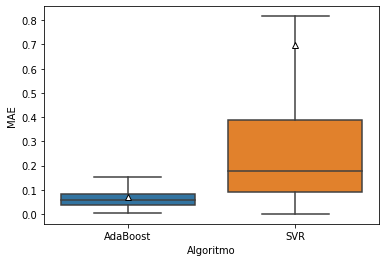

In [ ]:


aux_df = pd.DataFrame()
aux_df['AdaBoost'] = df_MAE_best_ada['MAE']
aux_df['SVR'] = df_MAE_best_svr['MAE']
#aux_df['KNR'] = df_MAE_best_knr['MAE']
#aux_df['Decision Tree'] = df_MAE_best_decision_tree['MAE']
#aux_df['Extra Tree'] = df_MAE_best_extra_tree['MAE']
#aux_df['MLP'] = df_MAE_best_mlp['MAE']
ax = sns.boxplot(data=aux_df,showfliers = False, showmeans=True,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}).set(
    xlabel='Algoritmo', 
    ylabel='MAE')  
plt.show()

plt.clf()
plt.close()

In [8]:
!tar -xvf "/home/nocs/TCC/Dataset/2013/homeA-all.tar.gz" -C "/home/nocs/TCC/Dataset/2013/HomeA-all/"

homeA-all/
homeA-all/homeA-door/
homeA-all/homeA-door/2012-Jul-10.csv
homeA-all/homeA-door/2012-Jul-11.csv
homeA-all/homeA-door/2012-Jul-12.csv
homeA-all/homeA-door/2012-Jul-13.csv
homeA-all/homeA-door/2012-Jul-14.csv
homeA-all/homeA-door/2012-Jul-15.csv
homeA-all/homeA-door/2012-Jul-16.csv
homeA-all/homeA-door/2012-Jul-17.csv
homeA-all/homeA-door/2012-Jul-18.csv
homeA-all/homeA-door/2012-Jul-1.csv
homeA-all/homeA-door/2012-Jul-19.csv
homeA-all/homeA-door/2012-Jul-20.csv
homeA-all/homeA-door/2012-Jul-21.csv
homeA-all/homeA-door/2012-Jul-22.csv
homeA-all/homeA-door/2012-Jul-23.csv
homeA-all/homeA-door/2012-Jul-24.csv
homeA-all/homeA-door/2012-Jul-25.csv
homeA-all/homeA-door/2012-Jul-26.csv
homeA-all/homeA-door/2012-Jul-27.csv
homeA-all/homeA-door/2012-Jul-28.csv
homeA-all/homeA-door/2012-Jul-2.csv
homeA-all/homeA-door/2012-Jul-29.csv
homeA-all/homeA-door/2012-Jul-30.csv
homeA-all/homeA-door/2012-Jul-31.csv
homeA-all/homeA-door/2012-Jul-3.csv
homeA-all/homeA-door/2012-Jul-4.csv
homeA-all

In [ ]:
del df_homeA
days = [x.timestamp() for x in pd.date_range(start="2012-05-01",end="2012-07-31", freq="S")]
df_homeA = pd.DataFrame({'TimestampUTC': days})
df_homeA.set_index('TimestampUTC', inplace=True)
df_homeA.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 518401 entries, 1335830400.0 to 1336348800.0
Empty DataFrame

In [9]:
import os
import re
from fnmatch import fnmatch
root = r'/content/homeA-all/'
data = []
all_directories = glob.glob(root+'*/')
for dir in all_directories:
  
    all_files = [f for f in  glob.glob(dir + "/*.csv")] #if re.search(r'2012-May-[1-7](-p[1-2])?.csv', f)]
    print(dir)
    header = loadtxt(dir + "/FORMAT",dtype=str,comments="#", delimiter=",", unpack=False)
    dfs = []
    dfs_p1 = []
    dfs_p2 = []
    for filename in all_files:
        #Le todos os arquivos no path e cria dataframes com os dados, colocando os dataframes
        #em um dicionario
        #linhas para achar o nome da casa, que é usado como chave no dicionario para encontrar
        #o dataframe da casa
        
        start = filename.find('2')
        end = filename.find('.', start)
        if "p1" in filename:
          df = pd.read_csv(filename, names=header)
          df.set_index('TimestampUTC', inplace=True)
          df = df.loc[~df.index.duplicated(keep='first')]
          #for column in df:
          #    if df[column].dtype is "float64":
          #      df[column] = df[column].astype('float32')
              #else:
              #  df[column] = df[column].astype('str')
          dfs_p1.append(df)
        elif "p2" in filename:
          df = pd.read_csv(filename, names=header)
          df.set_index('TimestampUTC', inplace=True)
          df = df.loc[~df.index.duplicated(keep='first')]
          #for column in df:
          #    if df[column].dtype is "float64":
          #      df[column] = df[column].astype('float32')
              #else:
              #  df[column] = df[column].astype('str')
          dfs_p2.append(df)
        else: 
           df = pd.read_csv(filename, names=header)

           #reverte o dataframe lido, pois ele esta na ordem reversa de tempo.
           #df = df[::-1]
           df.set_index('TimestampUTC', inplace=True)
           df = df.loc[~df.index.duplicated(keep='first')]
           #for column in df:
           #   if df[column].dtype is "float64":
           #     df[column] = df[column].astype('float32')
              #else:
              #  df[column] = df[column].astype('str')
           dfs.append(df)
    if dfs:
      df_homeA = pd.concat([df_homeA, pd.concat(dfs)], axis=1)
      df_homeA.info()
    if dfs_p1:
      df_homeA = pd.concat([df_homeA, pd.concat(dfs_p1)], axis=1)
    if dfs_p2:
      df_homeA = pd.concat([df_homeA, pd.concat(dfs_p2)], axis=1)
      


In [19]:


def carrega_home(root_path):
  root = root_path
  data = []
  all_directories = glob.glob(root+'*/')
  all_directories.sort()
  for dir in all_directories:

      all_files = [f for f in  glob.glob(dir + "/*.csv")] #if re.search(r'2012-May-[1-7](-p[1-2])?.csv', f)]
      print(dir)
      header = loadtxt(dir + "FORMAT",dtype=str,comments="#", delimiter=",", unpack=False)
      dfs = []
      dfs_p1 = []
      dfs_p2 = []
      for filename in all_files:

          start = filename.find('2')
          end = filename.find('.', start)
          if "p1" in filename:
            df = pd.read_csv(filename, names=header)
            df.set_index('TimestampUTC', inplace=True)
            df = df.loc[~df.index.duplicated(keep='first')]
            #for column in df:
            #    if df[column].dtype is "float64":
            #      df[column] = df[column].astype('float32')
                #else:
                #  df[column] = df[column].astype('str')
            dfs_p1.append(df)
          elif "p2" in filename:
            df = pd.read_csv(filename, names=header)
            df.set_index('TimestampUTC', inplace=True)
            df = df.loc[~df.index.duplicated(keep='first')]
            #for column in df:
            #    if df[column].dtype is "float64":
            #      df[column] = df[column].astype('float32')
                #else:
                #  df[column] = df[column].astype('str')
            dfs_p2.append(df)
          else: 
             df = pd.read_csv(filename, names=header)

             #reverte o dataframe lido, pois ele esta na ordem reversa de tempo.
             #df = df[::-1]
             df.set_index('TimestampUTC', inplace=True)
             df = df.loc[~df.index.duplicated(keep='first')]
             #for column in df:
             #   if df[column].dtype is "float64":
             #     df[column] = df[column].astype('float32')
                #else:
                #  df[column] = df[column].astype('str')
             dfs.append(df)
      if dfs:
        data.append(pd.concat(dfs))
      if dfs_p1:
        data.append(pd.concat(dfs_p1))
      if dfs_p2:
        data.append(pd.concat(dfs_p2))
  df_home = pd.concat(data,axis=1)
  return df_home


In [46]:
root = r'/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/'
df_homeA = carrega_home(root)
df_homeA.info()

/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-circuit/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-door/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-environmental/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-furnace/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-meter/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-motion/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-phase/
/home/nocs/TCC/Dataset/2013/HomeA-all/homeA-all/homeA-switch/
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7653941 entries, 1342775886 to 1336972660
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CircuitName               object 
 1   CircuitNumber             float64
 2   RealPowerWatts            float64
 3   ApparentPowerVAs          float64
 4   DoorSensorName            object 
 5   OpenOrClosed              object 
 6   insideTemp                float64
 7   outsideTemp       

In [20]:
df_homeA.describe()

,CircuitNumber,RealPowerWatts,ApparentPowerVAs,insideTemp,outsideTemp,insideHumidity,outsideHumidity,windSpeed,windGust,rainRate,...,RealPowerWatts,CircuitNumber,MotionOrNoMotion,FrequencyHz,VoltageVolts,FrequencyHz,VoltageVolts,MaxRealPowerWatts,DimProportion,CircuitNumber
count,5.474706e+06,5.474706e+06,5.474706e+06,26192.000000,26192.000000,26192.000000,26192.000000,26192.000000,26192.000000,26192.000000,...,6.342330e+05,634233.000000,143006.000000,7.470891e+06,7.423073e+06,7.470890e+06,7.423065e+06,30258.000000,30258.000000,30258.000000
mean,8.853380e+00,9.527756e+02,1.028635e+03,75.508889,67.174414,44.429364,72.970964,0.628297,1.575672,0.010394,...,6.903033e+01,6.934130,0.511111,5.999189e+01,1.213202e+02,5.999188e+01,1.221535e+02,102.110186,0.139909,15.662139
std,1.003792e+01,1.108861e+03,1.136314e+03,3.617095,11.308107,6.765626,19.995563,1.003732,2.009751,0.082581,...,7.604968e+03,5.863625,0.499878,1.965088e-02,9.616023e-01,1.974473e-02,9.222369e-01,86.333218,0.337239,5.739849
min,1.000000e+00,-4.170000e+00,-0.000000e+00,65.893997,27.860001,23.000000,23.000000,0.000000,0.000000,0.000000,...,0.000000e+00,3.000000,0.000000,5.989900e+01,1.099950e+02,5.989800e+01,1.105290e+02,20.000000,0.000000,7.000000
25%,1.000000e+00,1.124350e+02,2.159920e+02,73.039993,59.161999,41.000000,57.599998,0.000000,0.000000,0.000000,...,0.000000e+00,4.000000,0.000000,5.997800e+01,1.206720e+02,5.997800e+01,1.215220e+02,20.000000,0.000000,8.000000
50%,1.000000e+00,7.596945e+02,8.620270e+02,75.020004,66.595993,44.000000,78.099998,0.000000,1.000000,0.000000,...,0.000000e+00,4.000000,1.000000,5.998700e+01,1.213690e+02,5.998700e+01,1.221940e+02,60.000000,0.000000,20.000000
75%,2.100000e+01,1.301079e+03,1.402459e+03,77.000000,75.240507,48.000000,90.199997,1.000000,3.000000,0.000000,...,0.000000e+00,4.000000,1.000000,6.000800e+01,1.220360e+02,6.000800e+01,1.228230e+02,195.000000,0.000000,20.000000
max,2.600000e+01,1.055128e+04,1.112955e+04,89.239998,98.726006,66.000000,98.000000,8.000000,19.000000,4.320000,...,5.368709e+06,26.000000,1.000000,6.679200e+01,1.508310e+02,6.944800e+01,1.533960e+02,260.000000,1.000000,22.000000


In [47]:
df_homeA.columns = pd.io.parsers.base_parser.ParserBase({'names':df_homeA.columns, 'usecols':None})._maybe_dedup_names(df_homeA.columns)
df_homeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7653941 entries, 1342775886 to 1336972660
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CircuitName               object 
 1   CircuitNumber             float64
 2   RealPowerWatts            float64
 3   ApparentPowerVAs          float64
 4   DoorSensorName            object 
 5   OpenOrClosed              object 
 6   insideTemp                float64
 7   outsideTemp               float64
 8   insideHumidity            float64
 9   outsideHumidity           float64
 10  windSpeed                 float64
 11  windDirectionDegrees      object 
 12  windGust                  float64
 13  windGustDirectionDegrees  object 
 14  rainRate                  float64
 15  rain                      float64
 16  windChill                 float64
 17  heatindex                 float64
 18  ThermostatName            object 
 19  FurnaceOnOrOff            object 
 20  MeterName   

In [48]:
df_homeA.rename(columns={df_homeA.columns[0]: "CircuitName_Circuit",
                         df_homeA.columns[1]: "CircuitNumber_Circuit", 
                         df_homeA.columns[2]: "RealPowerWatts_Circuit",
                         df_homeA.columns[21]: "RealPowerWatts_Meter", 
                         df_homeA.columns[22]: "CircuitNumber_Meter", 
                         df_homeA.columns[25]: "FrequencyHz_P1",
                         df_homeA.columns[26]: "VoltageVolts_P1",
                         df_homeA.columns[27]: "FrequencyHz_P2",
                         df_homeA.columns[28]: "VoltageVolts_P2", 
                         df_homeA.columns[32]: "CircuitNumber_Switch"},inplace = True)
df_homeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7653941 entries, 1342775886 to 1336972660
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CircuitName_Circuit       object 
 1   CircuitNumber_Circuit     float64
 2   RealPowerWatts_Circuit    float64
 3   ApparentPowerVAs          float64
 4   DoorSensorName            object 
 5   OpenOrClosed              object 
 6   insideTemp                float64
 7   outsideTemp               float64
 8   insideHumidity            float64
 9   outsideHumidity           float64
 10  windSpeed                 float64
 11  windDirectionDegrees      object 
 12  windGust                  float64
 13  windGustDirectionDegrees  object 
 14  rainRate                  float64
 15  rain                      float64
 16  windChill                 float64
 17  heatindex                 float64
 18  ThermostatName            object 
 19  FurnaceOnOrOff            object 
 20  MeterName   

In [ ]:
df_homeA.index = pd.Series({x: x[1] if type(x) is tuple else x for x in df_homeA.index})

In [49]:
df_homeA.index = df_homeA.index.map(lambda x : datetime.utcfromtimestamp(x).strftime('%m %d %H:%M %S'))

In [ ]:
df_homeA = df_homeA.loc[~df_homeA.index.duplicated(keep='first')]

In [56]:
#df_homeA.insert(0, 'time_idx', range(0, len(df_homeA)))
#df_homeA.time_idx = df_homeA.time_idx.astype(int)
##for column in df_homeA:
##    if df_homeA[column].dtypes == np.float64:
##      df_homeA['log_' + column] = np.log(df_homeA[column],where=df_homeA[column] > 0) 
#df_homeA['Group'] = 0
#df_homeA['ThermostatName']=df_homeA['ThermostatName'].fillna("")
#df_homeA['CircuitName_Circuit']=df_homeA['CircuitName_Circuit'].fillna("")
#df_homeA['MeterName']=df_homeA['MeterName'].fillna("")
#df_homeA['SwitchName']=df_homeA['SwitchName'].fillna("")
#df_homeA['DoorSensorName']=df_homeA['DoorSensorName'].fillna("")
#df_homeA['MotionSensorName']=df_homeA['MotionSensorName'].fillna("")
#df_homeA[['ThermostatName', 'CircuitName_Circuit', 'MeterName', 'SwitchName','DoorSensorName','MotionSensorName']] = df_homeA[['ThermostatName', 'CircuitName_Circuit', 'MeterName', 'SwitchName','DoorSensorName','MotionSensorName']].astype('category')
df_homeA[['windDirectionDegrees', 'windGustDirectionDegrees']] = df_homeA[['windDirectionDegrees', 'windGustDirectionDegrees']].astype('float64')
df_homeA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7653941 entries, 07 20 09:18 06 to 05 14 05:17 40
Data columns (total 35 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   time_idx                  int64   
 1   CircuitName_Circuit       category
 2   CircuitNumber_Circuit     float64 
 3   RealPowerWatts_Circuit    float64 
 4   ApparentPowerVAs          float64 
 5   DoorSensorName            category
 6   OpenOrClosed              float64 
 7   insideTemp                float64 
 8   outsideTemp               float64 
 9   insideHumidity            float64 
 10  outsideHumidity           float64 
 11  windSpeed                 float64 
 12  windDirectionDegrees      float64 
 13  windGust                  float64 
 14  windGustDirectionDegrees  float64 
 15  rainRate                  float64 
 16  rain                      float64 
 17  windChill                 float64 
 18  heatindex                 float64 
 19  ThermostatName            c

In [54]:
print(df_homeA['windDirectionDegrees'].unique())

[nan '          ' '324.0     ' '165.0     ' '28.0      ' '183.0     '
 '227.0     ' '326.0     ' '144.0     ' '156.0     ' '354.0     '
 '82.0      ' '279.0     ' '317.0     ' '319.0     ' '284.0     '
 '149.0     ' '310.0     ' '135.0     ' '208.0     ' '237.0     '
 '51.0      ' '297.0     ' '333.0     ' '106.0     ' '177.0     '
 '288.0     ' '274.0     ' '120.0     ' '43.0      ' '171.0     '
 '110.0     ' '345.0     ' '273.0     ' '190.0     ' '201.0     '
 '174.0     ' '173.0     ' '92.0      ' '198.0     ' '131.0     '
 '158.0     ' '12.0      ' '139.0     ' '159.0     ' '306.0     '
 '192.0     ' '259.0     ' '195.0     ' '140.0     ' '151.0     '
 '108.0     ' '265.0     ' '258.0     ' '357.0     ' '290.0     '
 '117.0     ' '142.0     ' '145.0     ' '147.0     ' '276.0     '
 '14.0      ' '36.0      ' '344.0     ' '352.0     ' '10.0      '
 '0.0       ' '334.0     ' '340.0     ' '296.0     ' '327.0     '
 '282.0     ' '315.0     ' '308.0     ' '270.0     ' '299.0     '
 '337.

In [55]:
df_homeA = df_homeA.replace(r'^\s*$', np.nan, regex=True)


In [ ]:
df_homeA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 604571 entries, 05 01 00:00 00 to 04 30 23:59 45
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   time_idx                  604571 non-null  int64   
 1   insideTemp                287 non-null     float64 
 2   outsideTemp               287 non-null     float64 
 3   insideHumidity            287 non-null     float64 
 4   outsideHumidity           287 non-null     float64 
 5   windSpeed                 287 non-null     float64 
 6   windDirectionDegrees      120 non-null     object  
 7   windGust                  287 non-null     float64 
 8   windGustDirectionDegrees  120 non-null     object  
 9   rainRate                  287 non-null     float64 
 10  rain                      287 non-null     float64 
 11  windChill                 287 non-null     float64 
 12  heatindex                 287 non-null     float64 
 13  ThermostatNam

In [ ]:
df_homeA.drop(['ThermostatName', 'CircuitName', 'MeterName', 'SwitchName','DoorSensorName','MotionSensorName'], axis=1, inplace=True)
print(df_homeA.columns)

Index(['time_idx', 'CircuitName_Circuit', 'CircuitNumber_Circuit',
       'RealPowerWatts_Circuit', 'OpenOrClosed', 'insideTemp', 'outsideTemp',
       'insideHumidity', 'outsideHumidity', 'windSpeed', 'windGust',
       'rainRate', 'rain', 'windChill', 'heatindex ', 'FurnaceOnOrOff',
       'RealPowerWatts_Meter', 'CircuitNumber_Meter', 'MotionOrNoMotion',
       'FrequencyHz_P1', 'VoltageVolts_P1', 'FrequencyHz_P2',
       'VoltageVolts_P2', 'MaxRealPowerWatts', 'DimProportion',
       'CircuitNumber_Switch', 'Group'],
      dtype='object')


In [ ]:
import math
for i in df_homeA['heatindex ']:
  if isinstance(i,str):
    print(i)
  elif not math.isnan(i):
    print(i)

61.772011
60.799999
59.864002
58.675995
57.325996
56.102001
55.63401
55.202003
54.266003
53.527996
52.556
51.746002
51.835999
51.764
51.691998
50.936001
50.143997
49.603996
49.459995
49.711998
49.603996
49.495998
48.919994
48.434002
48.037998
47.858002
47.461994
47.551998
47.498001
47.191998
47.173996
47.498001
47.551998
46.633995
46.003998
45.859997
45.733997
46.004005
45.967999
45.806
45.175999
44.797997
44.36599
44.347992
44.347996
44.221992
43.970001
43.808006
43.880001
43.754002
43.232002
42.872002
42.709999
42.476002
42.763996
42.314007
42.386002
42.188007
42.008003
41.809998
41.540001
41.504005
41.306
41.450005
41.431999
41.18
41.161995
40.676003
40.531998
40.046005
39.902004
40.064003
39.920006
39.848
39.614002
39.380001
39.344002
39.380001
39.470001
39.434002
39.379997
39.848
39.613995
39.560001
39.703999
39.829994
39.739998
39.487999
39.452003
39.145996
38.696003
38.93
39.326004
39.686005
39.793999
39.416004
39.308006
39.290001
39.506001
39.542
39.434002
39.739998
39.848
39.5

In [57]:
max_prediction_length = 6
max_encoder_length = 24
df_homeA.time_idx = df_homeA.time_idx.astype(int)
training_cutoff = df_homeA["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
                            df_homeA[lambda x: x.time_idx <= training_cutoff],
                            time_idx="time_idx",
                            target="RealPowerWatts_Circuit",
                            group_ids=["Group"],
                            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
                            max_encoder_length=max_encoder_length,
                            min_prediction_length=1,
                            max_prediction_length=max_prediction_length,
                            #time_varying_known_categoricals=["ThermostatName", 
                            #                                 "CircuitName", 
                            #                                 "SwitchName", 
                            #                                 "DoorSensorName", 
                            #                                 "MeterName"],
                        
                            time_varying_known_reals=["time_idx",
                                                      "CircuitNumber_Circuit",
                                                      "CircuitNumber_Meter",
                                                      "CircuitNumber_Switch"],
                            time_varying_unknown_categoricals=[],
                            time_varying_unknown_reals=["RealPowerWatts_Meter",
                                                        "insideTemp",
                                                        "outsideTemp",              
                                                        "insideHumidity",
                                                        "outsideHumidity",           
                                                        "windSpeed",              
                                                        "windDirectionDegrees",   
                                                        "windGust",                  
                                                        "windGustDirectionDegrees",  
                                                        "rainRate",  
                                                        "rain",  
                                                        "windChill",  
                                                        "heatindex ",  
                                                        "FurnaceOnOrOff", 
                                                        "RealPowerWatts_Circuit",  
                                                        "ApparentPowerVAs",  
                                                        "MotionOrNoMotion",              
                                                        "MaxRealPowerWatts",         
                                                        "DimProportion",         
                                                        "OpenOrClosed",         
                                                        "FrequencyHz_P1",         
                                                        "VoltageVolts_P1",         
                                                        "FrequencyHz_P2",         
                                                        "VoltageVolts_P2"         
                            ],
                            target_normalizer=GroupNormalizer(
                                groups=["Group"], transformation="softplus"
                            ),  # use softplus and normalize by group
                            add_relative_time_idx=True,
                            add_target_scales=True,
                            add_encoder_length=True,
                            allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, df_homeA, predict=True, stop_randomization=True)
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

ValueError: 2179229 (28.47%) of RealPowerWatts_Circuit values were found to be NA or infinite (even after encoding). NA values are not allowed `allow_missing_timesteps` refers to missing rows, not to missing values. Possible strategies to fix the issue are (a) dropping the variable RealPowerWatts_Circuit, (b) using `NaNLabelEncoder(add_nan=True)` for categorical variables, (c) filling missing values and/or (d) optionally adding a variable indicating filled values

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
pl.seed_everything(0)
trainer = pl.Trainer(
    gpus=0,
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,  
    hidden_continuous_size=8,  
    output_size=7, 
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.002,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
)

with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print(study.best_trial.params)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()